# Fourier Transform of Sunspot Data

In this notebook I perform a *fast fourier transform* (fft) of the smoothed sunspot data, in order to compare it with the kernel functions. 

The idea is to find the kernel which best describes the fft and implement that in our GP.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks

from scipy.signal import find_peaks
from scipy.signal import argrelmin

In [2]:
# Load sunspot data into a numpy array
df = pd.read_csv('../Data/SN_d_tot_V2.0.csv', delimiter=';')
xcol = 'Date in Fraction of Year'
ycol = 'Number of Sunspots'

#df.drop(columns=['Unnamed: 0'], inplace=True)
#df.set_index("Year", inplace=True)

In [8]:
# Compute sampling rate
sampling_rate = 1.0 / (df[xcol].iloc[1] - df[xcol].iloc[0])

# Compute FFT of the data
fft_data = np.fft.fft(df[ycol].values)

# Compute power spectrum
power_spectrum = np.abs(fft_data)**2

# Compute corresponding frequencies
freqs = np.fft.fftfreq(len(df[ycol]), 1/sampling_rate)

In [36]:
peaks = find_peaks(power_spectrum[:len(power_spectrum)//2], height=5e11, distance=1)
maxima = power_spectrum[peaks[0]]
dates_peak = 1/freqs[:len(power_spectrum)//2][peaks[0]]

print(peaks[1])
print(dates_peak)

{'peak_heights': array([9.44900292e+11, 7.78702291e+11, 5.07742499e+12])}
[112.1745     13.197      11.8078421]


<ipython-input-38-d24c3c383cf3>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freqs[:len(power_spectrum)//2], power_spectrum[:len(power_spectrum)//2])


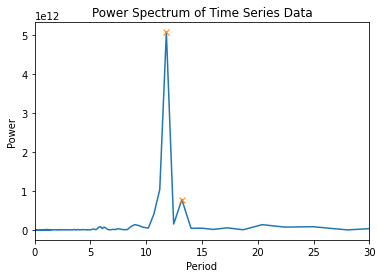

In [38]:

# Plot power spectrum
plt.plot(1/freqs[:len(power_spectrum)//2], power_spectrum[:len(power_spectrum)//2])
plt.plot(dates_peak, maxima, 'x')
plt.title("Power Spectrum of Time Series Data")
plt.xlabel("Period")
plt.ylabel("Power")
plt.xlim(0,30)

#peaks, _ = find_peaks(power_spectrum, height=0.5e12)
#plt.plot(freqs[peaks], power_spectrum[peaks], 'x');

plt.show()

#### Comment on plot:

As we can see from the FFT, we have a spike at a period of ~ 11 years, which is to be expected. There is also another spike around 13 years, and when we see the whole figure there also seems to be a periodicity of around ~ 100 years.

In [4]:
# Kernels:

def SE(x1, x2, l):
    return np.exp(-(x1-x2)**2/(2*l**2))

def RQ(x1, x2, alpha, l):
       return (1 + np.exp(-(x1-x2)**2/(2*alpha*l**2)))**(-alpha)
    
def Periodic(x1, x2, p, l):
    return np.exp((-2*np.sin(np.pi * np.abs(x1 - x2)/p)**2)/l**2)

In [5]:
# Define the range of input locations
X_new = np.linspace(0,15)

# Calculate the kernel values between two input locations
kernel_values = np.zeros((len(X_new), len(X_new)))
for i in range(len(X_new)):
    for j in range(len(X_new)):
        kernel_values[i, j] = SE(X_new[i], X_new[j], l=9.8)

kernel_values2 = np.zeros((len(X_new), len(X_new)))
for i in range(len(X_new)):
    for j in range(len(X_new)):
        kernel_values2[i, j] = Periodic(X_new[i], X_new[j], l=0.58, p=11) 

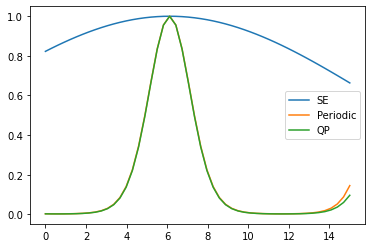

In [6]:
num = 20
plt.plot(X_new, kernel_values[num], label='SE')
plt.plot(X_new, kernel_values2[num], label='Periodic')
plt.plot(X_new, kernel_values[num]*kernel_values2[num], label='QP')
plt.legend();